In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords


In [5]:
data = pd.read_csv('/sms.csv')

In [6]:
data.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [8]:
data.isnull().sum()

sms      0
label    0
dtype: int64

Text(0.5, 1.0, 'Распределение смс')

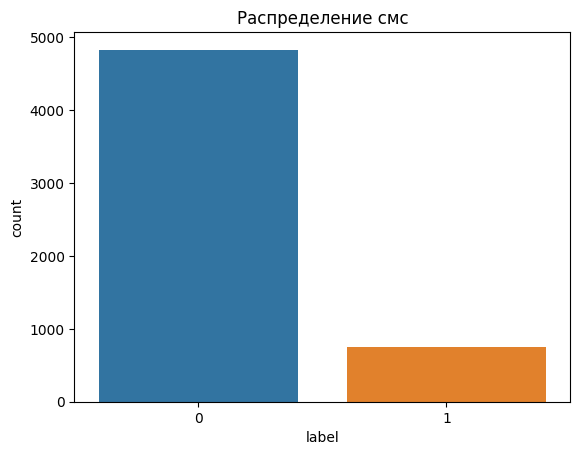

In [9]:
sns.countplot(x = "label", data = data)
plt.title("Распределение смс")

In [10]:
data['label'].value_counts()

0    4827
1     747
Name: label, dtype: int64

In [11]:
data = pd.concat([data[data["label"] == 0].sample(747), data[data["label"] == 1].sample(747)])

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stopwords = stopwords.words('english')

In [14]:
def preprocessing(data, stopwords):
    data['sms'] = data['sms'].str.lower()
    data['sms'] = data['sms'].str.replace('[^A-Za-z0-9]+', ' ', regex=True)
    data['sms'] = data['sms'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))

    return data

In [15]:
data = preprocessing(data, stopwords)

In [20]:
%pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00


In [21]:
%pip install transformers

In [14]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [19]:
train_sms, valid_sms, train_label, valid_label = train_test_split(data["sms"], data["label"], test_size=0.2)

In [20]:
tokens = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [22]:
train_encoding = tokens.batch_encode_plus(train_sms.tolist(), truncation=True, padding=True, max_length=500)
valid_encoding = tokens.batch_encode_plus(valid_sms.tolist(), truncation=True, padding=True, max_length=500)


In [23]:
train_label = torch.tensor(train_label.tolist())
valid_label = torch.tensor(valid_label.tolist())

In [24]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encoding['input_ids']), torch.tensor(train_encoding['attention_mask']), train_label)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

In [27]:
model.train()
for epoch in range(3):
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

In [29]:
model.eval()
valid_outputs = model(torch.tensor(valid_encoding['input_ids']), attention_mask=torch.tensor(valid_encoding['attention_mask']))
valid_logits = valid_outputs.logits
valid_predictions = torch.argmax(valid_logits, dim=1)
valid_accuracy = accuracy_score(valid_label, valid_predictions)
valid_precision, valid_recall, valid_f1, _ = precision_recall_fscore_support(valid_label, valid_predictions, average='binary')

In [30]:
print("Доля правильных ответов:", valid_accuracy)
print("Точность:", valid_precision)
print("Полнота:", valid_recall)
print("Оценка F1:", valid_f1)

Доля правильных ответов: 0.9765886287625418
Точность: 0.993421052631579
Полнота: 0.9617834394904459
Оценка F1: 0.9773462783171522


In [55]:
text = "I love DistilBERT!"

In [56]:
encode = tokens.encode_plus(text, truncation=True, padding=True, max_length=500, return_tensors='pt')

In [57]:
model.eval()
with torch.no_grad():
    outputs = model(encoding['input_ids'], attention_mask=encoding['attention_mask'])
    logits = outputs[0]
    predictions = torch.argmax(logits, dim=1)

In [58]:
if prediction == 1:
    print("The text is spam.")
else:
    print("The text is not spam.")

The text is not spam.


Выбор DistilBERT обусловлен тем, что это быстрая версия BERT, которая по-прежнему обеспечивает производительность, аналогичную производительности более крупных моделей, во многих задачах, включая классификацию текста.